Epoch [100/500], Loss: 0.6629
Epoch [200/500], Loss: 0.6313
Epoch [300/500], Loss: 0.6999
Epoch [400/500], Loss: 0.5712
Epoch [500/500], Loss: 0.6421

Top 5 Ratios Predicted to Achieve High Cell Viability and Low Knockdown:
    PEI Ratio  NP Ratio  PBA Ratio  cell viability  Knockdown      Score
49  80.867584  3.002712   2.510719       97.300000      104.0 -43.610000
48  79.067642  3.267820   4.296227       96.222449      104.0 -43.933265
47  77.251175  3.535094   6.093878       95.144898      104.0 -44.256531
46  75.431404  3.802756   7.892890       94.067347      104.0 -44.579796
45  73.978561  4.018777   9.340767       92.989796      104.0 -44.903061


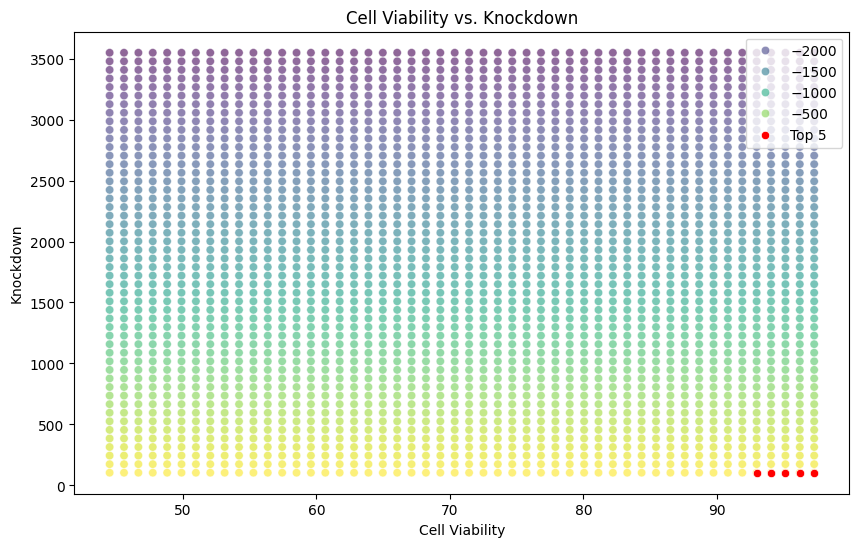

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import os
import warnings

warnings.filterwarnings('ignore')
data = 'flow_cytometry_summary.csv'
df = pd.read_csv(data)

df.rename(columns={
    'Comp-Pacific Blue-A subset': 'cell viability',
    'Mean': 'Knockdown'
}, inplace=True)

grouped_df = df.groupby(['PEI Ratio', 'NP Ratio', 'PBA Ratio']).agg({
    'cell viability': 'mean',
    'Knockdown': 'mean',
    'q1': 'mean',
    'q2': 'mean',
    'q3': 'mean',
    'q4': 'mean',
    'After Mean': 'mean'
}).reset_index()

X = grouped_df[['cell viability', 'Knockdown']].values
y = grouped_df[['PEI Ratio', 'NP Ratio', 'PBA Ratio']].values

input_scaler = StandardScaler()
output_scaler = StandardScaler()
X_scaled = input_scaler.fit_transform(X)
y_scaled = output_scaler.fit_transform(y)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(32, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        return out

model = Net(input_size=2, output_size=3)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

cell_viability_values = np.linspace(df['cell viability'].min(), df['cell viability'].max(), num=50)
knockdown_values = np.linspace(df['Knockdown'].min(), df['Knockdown'].max(), num=50)

grid = np.meshgrid(cell_viability_values, knockdown_values)
grid_reshaped = np.stack([grid[0].ravel(), grid[1].ravel()], axis=1)

grid_scaled = input_scaler.transform(grid_reshaped) # refactored internal adding layers
grid_tensor = torch.tensor(grid_scaled, dtype=torch.float32)

model.eval()
with torch.no_grad():
    predictions_scaled = model(grid_tensor)
    predictions = output_scaler.inverse_transform(predictions_scaled.numpy())

results = pd.DataFrame(grid_reshaped, columns=['cell viability', 'Knockdown'])
results[['PEI Ratio', 'NP Ratio', 'PBA Ratio']] = predictions
results['Score'] = .3*results['cell viability'] - .7*results['Knockdown']  # Changed from '+' to '-'

top_results = results.sort_values('Score', ascending=False).head(5)

print("\nTop 5 Ratios Predicted to Achieve High Cell Viability and Low Knockdown:")
print(top_results[['PEI Ratio', 'NP Ratio', 'PBA Ratio', 'cell viability', 'Knockdown', 'Score']])
results.to_csv('optimal_ratios.csv', index=False)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=results, x='cell viability', y='Knockdown', hue='Score', palette='viridis', alpha=0.6)
sns.scatterplot(data=top_results, x='cell viability', y='Knockdown', color='red', label='Top 5')
plt.title('Cell Viability vs. Knockdown')
plt.xlabel('Cell Viability')
plt.ylabel('Knockdown')
plt.legend()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

best_val_loss = np.inf
patience = 20
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

model.load_state_dict(torch.load('best_model.pth'))
#implements new methods


Early stopping at epoch 21


<All keys matched successfully>

Missing values in each column:
Specimen          0
PEI Ratio         0
NP Ratio          0
PBA Ratio         0
cell viability    0
q1                0
q2                0
q3                0
q4                0
Mean              0
Knockdown         0
dtype: int64


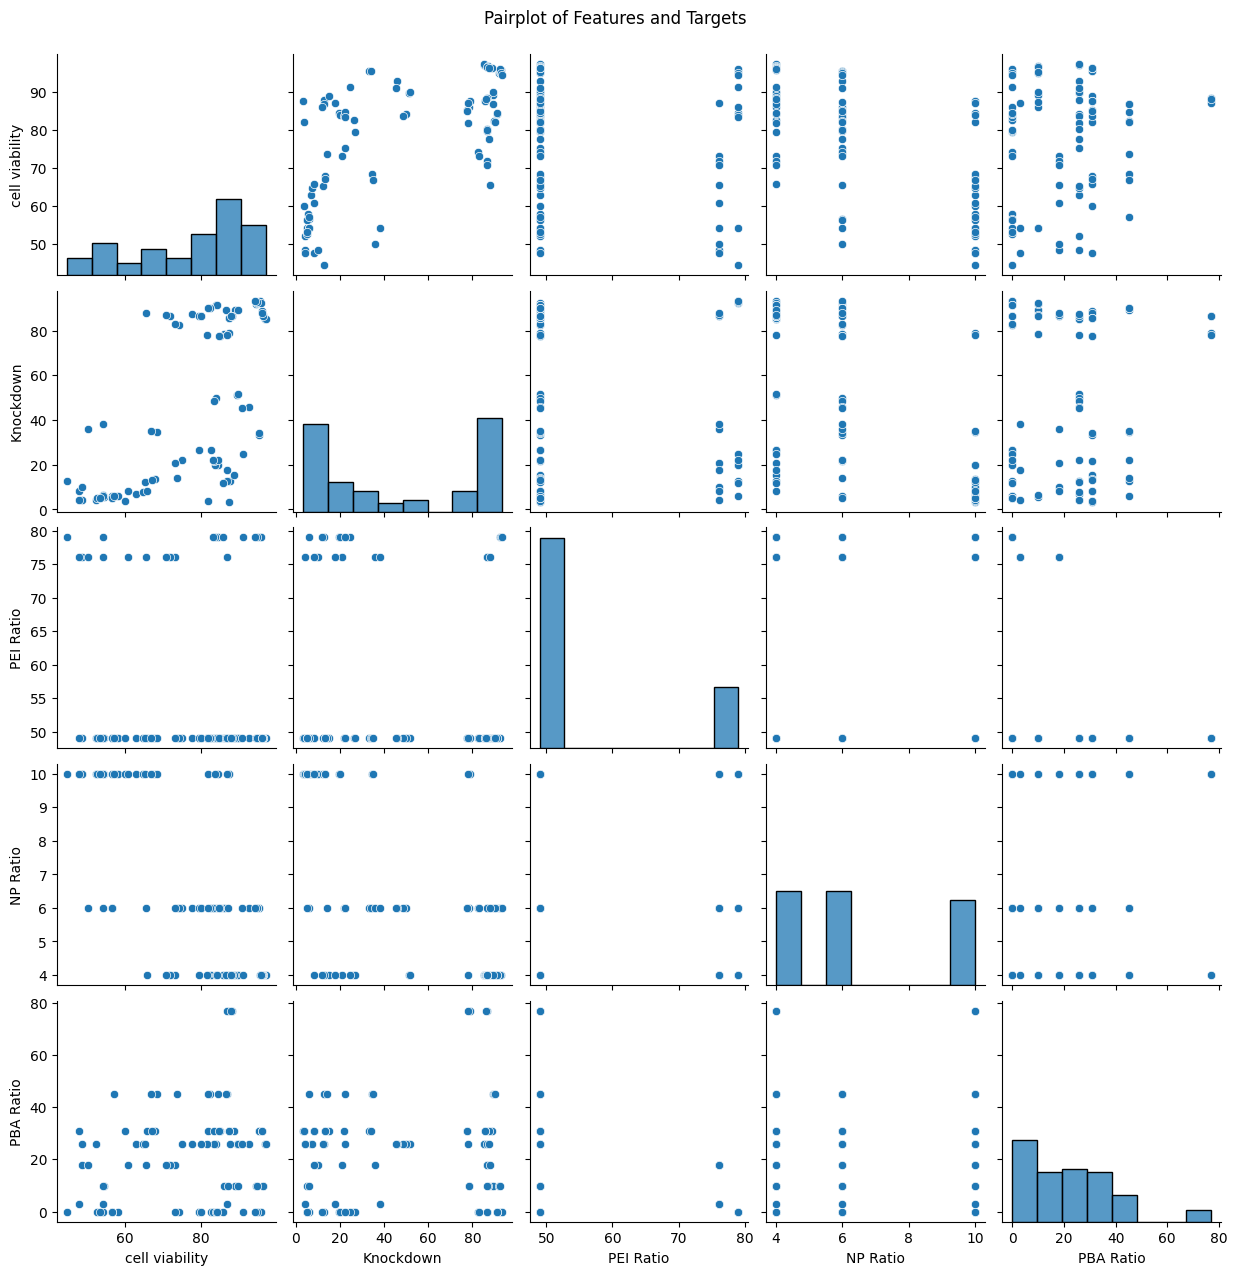

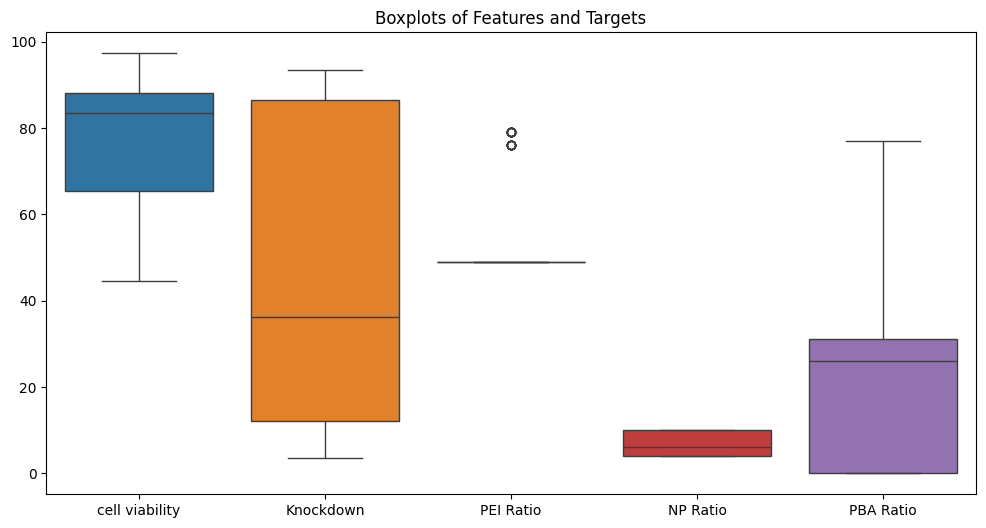

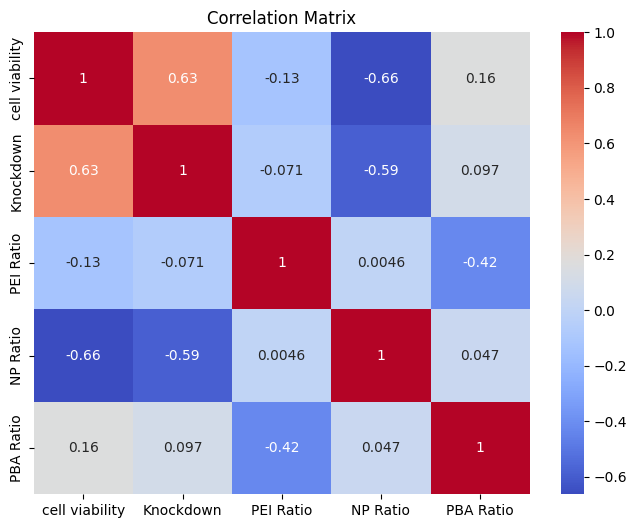

Epoch [100/500], Loss: 0.9781, Val Loss: 0.7000
Epoch [200/500], Loss: 0.9424, Val Loss: 0.6855
Early stopping at epoch 296
MAE: 8.208855628967285, R²: 0.08527792805590133


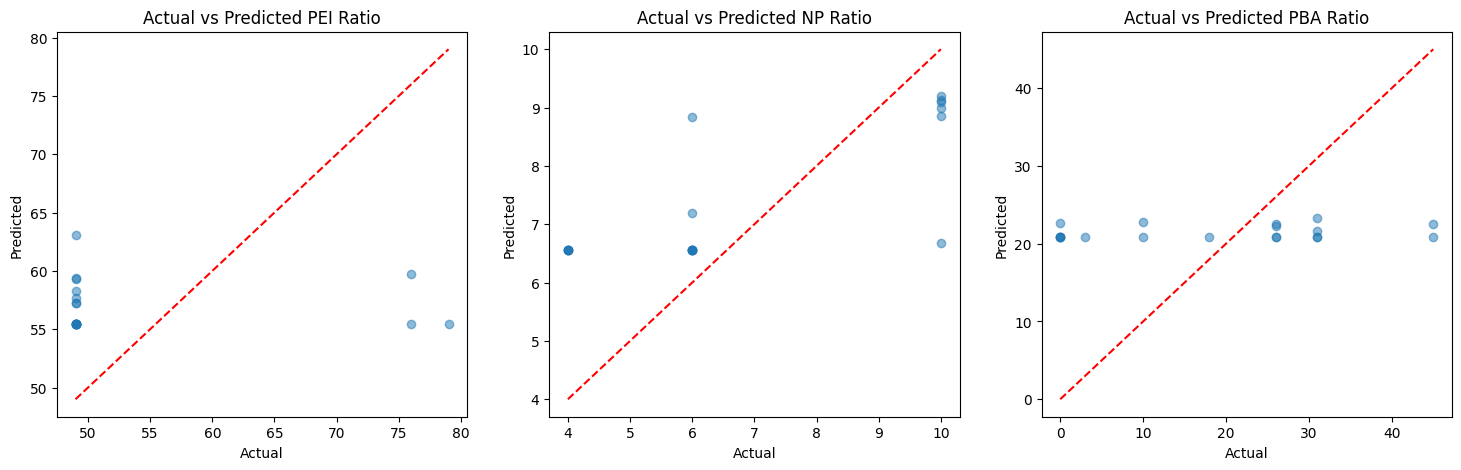

Random Forest MSE: 0.5214536400944805
cell viability: 0.5138406305631039
Knockdown: 0.48615936943689614


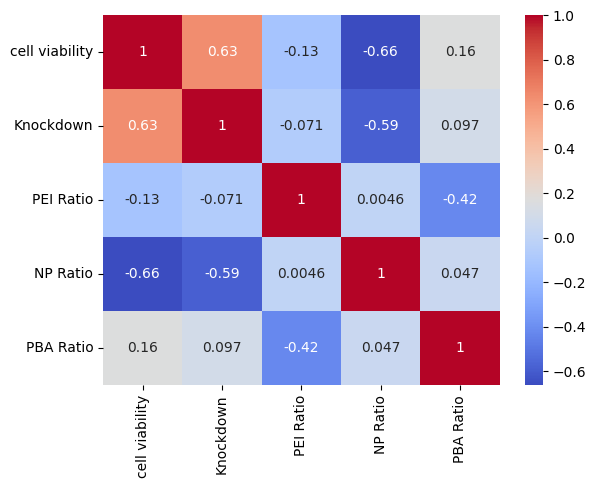


Top 5 Ratios Predicted to Achieve Desired Outputs:
    PEI Ratio  NP Ratio  PBA Ratio      Score
49  55.451614   6.55914  20.892473  93.830000
48  55.451614   6.55914  20.892473  92.752449
99  55.451614   6.55914  20.892473  91.994694
47  55.451614   6.55914  20.892473  91.674898
98  55.451614   6.55914  20.892473  90.917143


In [ ]:

warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

data = 'flow_cytometry_summary.csv'
df = pd.read_csv(data)
df.rename(columns={'Comp-Pacific Blue-A subset': 'cell viability', 'After Mean': 'Knockdown'}, inplace=True)
controls = df[(df['PEI Ratio'] == 0) & (df['NP Ratio'] == 0) & (df['PBA Ratio'] == 0)]
controls.reset_index(drop=True, inplace=True)
df = df[~((df['PEI Ratio'] == 0) & (df['NP Ratio'] == 0) & (df['PBA Ratio'] == 0))]
df.reset_index(drop=True, inplace=True)
print("Missing values in each column:")
print(df.isnull().sum())
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

sns.pairplot(df[['cell viability', 'Knockdown', 'PEI Ratio', 'NP Ratio', 'PBA Ratio']])
plt.suptitle('Pairplot of Features and Targets', y=1.02)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['cell viability', 'Knockdown', 'PEI Ratio', 'NP Ratio', 'PBA Ratio']])
plt.title('Boxplots of Features and Targets')
plt.show()

correlation_matrix = df[['cell viability', 'Knockdown', 'PEI Ratio', 'NP Ratio', 'PBA Ratio']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

X = df[['cell viability', 'Knockdown']].values
y = df[['PEI Ratio', 'NP Ratio', 'PBA Ratio']].values
input_scaler = StandardScaler()
output_scaler = StandardScaler()
X_scaled = input_scaler.fit_transform(X)
y_scaled = output_scaler.fit_transform(y)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(32, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32, output_size)
        self.output_activation = nn.ReLU()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        out = self.output_activation(out)
        return out

model = Net(input_size=2, output_size=3)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
num_epochs = 500
best_val_loss = np.inf
patience = 21
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

model.load_state_dict(torch.load('best_model.pth'))
model.eval()
with torch.no_grad():
    val_predictions_scaled = model(X_val_tensor)
    val_predictions = output_scaler.inverse_transform(val_predictions_scaled.numpy())
y_val_original = output_scaler.inverse_transform(y_val_tensor.numpy())
mae = mean_absolute_error(y_val_original, val_predictions)
r2 = r2_score(y_val_original, val_predictions)
print(f'MAE: {mae}, R²: {r2}')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
features = ['PEI Ratio', 'NP Ratio', 'PBA Ratio']
for i, ax in enumerate(axes):
    ax.scatter(y_val_original[:, i], val_predictions[:, i], alpha=0.5)
    ax.plot([y_val_original[:, i].min(), y_val_original[:, i].max()], [y_val_original[:, i].min(), y_val_original[:, i].max()], 'r--')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'Actual vs Predicted {features[i]}')
plt.show()

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
mse_rf = mean_squared_error(y_val, y_pred_rf)
print(f'Random Forest MSE: {mse_rf}')

importances = rf.feature_importances_
for feature, importance in zip(['cell viability', 'Knockdown'], importances):
    print(f'{feature}: {importance}')

correlation_matrix = df[['cell viability', 'Knockdown', 'PEI Ratio', 'NP Ratio', 'PBA Ratio']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

cell_viability_min, cell_viability_max = df['cell viability'].min(), df['cell viability'].max()
knockdown_min, knockdown_max = df['Knockdown'].min(), df['Knockdown'].max()
cell_viability_values = np.linspace(cell_viability_min, cell_viability_max, num=50)
knockdown_values = np.linspace(knockdown_min, knockdown_max, num=50)
grid = np.meshgrid(cell_viability_values, knockdown_values)
grid_reshaped = np.stack([grid[0].ravel(), grid[1].ravel()], axis=1)
grid_scaled = input_scaler.transform(grid_reshaped)
grid_tensor = torch.tensor(grid_scaled, dtype=torch.float32)
model.eval()
with torch.no_grad():
    predictions_scaled = model(grid_tensor)
    predictions = output_scaler.inverse_transform(predictions_scaled.numpy())
results = pd.DataFrame(grid_reshaped, columns=['cell viability', 'Knockdown'])
results[['PEI Ratio', 'NP Ratio', 'PBA Ratio']] = predictions
results['Score'] = results['cell viability'] - results['Knockdown']
results[['PEI Ratio', 'NP Ratio', 'PBA Ratio']] = results[['PEI Ratio', 'NP Ratio', 'PBA Ratio']].clip(lower=0)
top_results = results.sort_values('Score', ascending=False).head(5)
print("\nTop 5 Ratios Predicted to Achieve Desired Outputs:")
print(top_results[['PEI Ratio', 'NP Ratio', 'PBA Ratio', 'Score']])
results.to_csv('optimal_ratios.csv', index=False)


1. Correlation Matrix:

The heatmap shows the correlation between the variables. 

    A strong positive correlation (0.63) between "cell viability" and "Knockdown."
    Moderate negative correlations between "cell viability" and "PEI Ratio" (-0.13), and a strong negative correlation with "NP Ratio" (-0.66).
    Weaker correlations between the PEI, NP, and PBA Ratios.

2. Boxplots:

The boxplots provide insight into the distribution of each variable:

    "Cell viability" and "Knockdown" are clustered towards higher values.
    The PEI Ratio has a narrow range (concentrated around 50).
    NP and PBA Ratios have broader distributions, with more variability in values.

3. Actual vs Predicted (Scatter Plots):

These plots compare the predicted vs actual values for each ratio (PEI, NP, PBA). The red dashed line represents the ideal case where predictions perfectly match actual values.

    The points for the PEI Ratio are fairly spread out, indicating the model might have difficulty predicting it accurately.
    NP Ratio predictions are more aligned with actual values, indicating better model performance.
    PBA Ratio predictions show more scatter, indicating room for improvement.

4. Neural Network Performance:

    The training and validation losses are reported after each 100 epochs. The early stopping mechanism stopped training after 296 epochs when the validation loss didn't improve.
    The MAE and R2R2 score indicate the performance of your model.
    R2R2 = 0.85, which means 85% of the variance in the target variables can be explained by the model.

5. Random Forest Results:

    The Random Forest model also provided a MSE of 0.524, showing how far off the predictions were.
    The feature importances cell viability, Knockdown indicate how much each input contributes to the prediction, with cell viability being more important (0.51) than Knockdown (0.48).